<a href="https://colab.research.google.com/github/fxlmer/AJPom_cancer/blob/main/Ex3_ResNet50_nmVSpmd_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [ ]:
!nvidia-smi

Tue Apr  6 07:51:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import shutil
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from Ex2_DenseNet121_nmVSpmd_utils import *

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [ ]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 2

LR = 1e-5 # Learning rate

# Data Preparation

In [ ]:
!git clone https://github.com/EvilPickle-PCSHSPT/AJPom_cancer_data

fatal: destination path 'AJPom_cancer_data' already exists and is not an empty directory.


In [ ]:
train_path = '/content/AJPom_cancer_data/nmVSpmd/split_images_clf/train' 
val_path = '/content/AJPom_cancer_data/nmVSpmd/split_images_clf/validate'
test_path = '/content/AJPom_cancer_data/nmVSpmd/split_images_clf/test'

## Data Augmentation

In [ ]:
train_aug = ImageDataGenerator(rescale=1./255)

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 425 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


# Model

## Build Model

In [ ]:
def build_model_ResNet50():
  base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  # dense1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(average_pooling_layer)
  # # dense2 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense1)
  # dense3 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense1)
  # dense4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense3)
  # dense5 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense4)
  # dropout1 = Dropout(0.5)(dense5)
  prediction_layer = Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(average_pooling_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  return model

In [ ]:
model = build_model_ResNet50()

94674944/94668760 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [ ]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='Ex3_ResNet50_nmVSpmd_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [ ]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
14/14 [==============================] - ETA: 0s - batch: 6.5000 - size: 30.3571 - loss: 0.5846 - accuracy: 0.6729

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14/14 [==============================] - 48s 2s/step - batch: 6.5000 - size: 30.3571 - loss: 0.5846 - accuracy: 0.6729 - val_loss: 0.4888 - val_accuracy: 0.7213
Epoch 2/100
14/14 [==============================] - 12s 915ms/step - batch: 6.5000 - size: 30.3571 - loss: 0.2715 - accuracy: 0.9412 - val_loss: 0.3745 - val_accuracy: 0.8361
Epoch 3/100
14/14 [==============================] - 27s 2s/step - batch: 6.5000 - size: 30.3571 - loss: 0.1597 - accuracy: 0.9929 - val_loss: 0.3210 - val_accuracy: 0.8525
Epoch 4/100
14/14 [==============================] - 27s 2s/step - batch: 6.5000 - size: 30.3571 - loss: 0.1240 - accuracy: 0.9906 - val_loss: 0.2958 - val_accuracy: 0.8689
Epoch 5/100
14/14 [==============================] - 27s 2s/step - batch: 6.5000 - size: 30.3571 - loss: 0.0760 - accuracy: 1.0000 - val_loss: 0.2703 - val_accuracy: 0.8689
Epoch 6/100
14/14 [==============================] - 27s 2s/step - batch: 6.5000 - size: 30.3571 - loss: 0.0841 - accuracy: 0.9953 - val_loss: 0

# Training Graph

## Accuracy

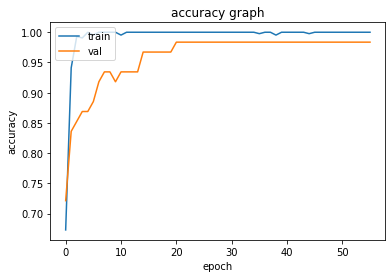

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy graph')
plt.show()

## Loss

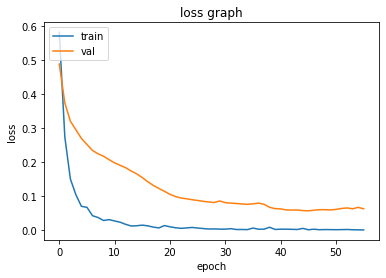

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss graph')
plt.show()

# Evaluation

In [ ]:
test_model = tf.keras.models.load_model('/content/Ex3_ResNet50_nmVSpmd_model.h5')

In [ ]:
num_test_files = len(test_generator.filenames)

In [ ]:
test_generator.reset()

In [ ]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix


### Without Normalize

Confusion matrix, without normalization
[[55  5]
 [ 1 61]]


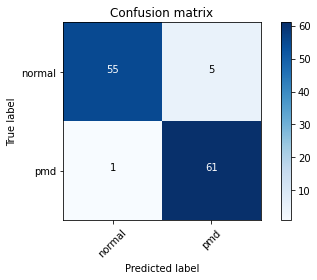

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['normal', 'pmd']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.91666667 0.08333333]
 [0.01612903 0.98387097]]


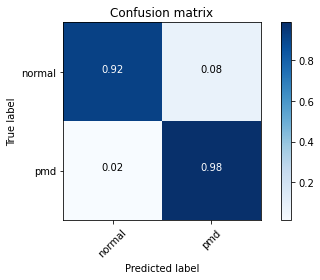

In [ ]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [ ]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[55  5]
 [ 1 61]]
Classification Report
              precision    recall  f1-score   support

      normal       0.98      0.92      0.95        60
         pmd       0.92      0.98      0.95        62

    accuracy                           0.95       122
   macro avg       0.95      0.95      0.95       122
weighted avg       0.95      0.95      0.95       122



## TP FP FN TN

In [ ]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [ ]:
TruePositive= np.diag(cm_2)

In [ ]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[55 61]
Sum of True Positive:  116


### FP

In [ ]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [ ]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[1, 5]
Sum of False Positive:  6


### FN

In [ ]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [ ]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[5, 1]
Sum of False Negative:  6


### TN

In [ ]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [ ]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[61, 55]
Sum of True Negative:  116


### Check TP + FP + FN + TN = Test set

In [ ]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True


## ROC
https://qiita.com/bmj0114/items/460424c110a8ce22d945

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
auc_keras = auc(fpr, tpr)
roc_auc = auc(fpr, tpr)

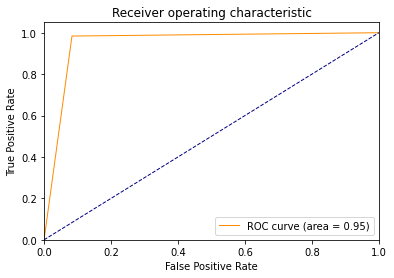

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Precision-Recall curve
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [ ]:
probs = predictions[:, 1]

In [ ]:
precision, recall, _ = precision_recall_curve(test_labels, probs)

In [ ]:
f1, auc = f1_score(test_labels, y_pred), auc(recall, precision)

In [ ]:
test_labels = len(test_labels[test_labels==1]) / len(test_labels)

No handles with labels found to put in legend.


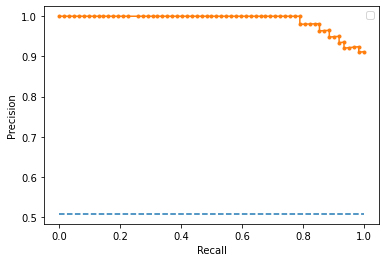

In [ ]:
plt.plot([0, 1], [test_labels, test_labels], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## PYCM

In [ ]:
!pip3 install pycm==3.0 

In [ ]:
from pycm import *

In [ ]:
test_labels = test_generator.classes

In [ ]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [ ]:
py_cm.classes

[0, 1]

In [ ]:
py_cm.table

{0: {0: 55, 1: 5}, 1: {0: 1, 1: 61}}

In [ ]:
print(py_cm)

Predict  0        1        
Actual
0        55       5        

1        1        61       





Overall Statistics : 

95% CI                                                            (0.91245,0.98919)
ACC Macro                                                         0.95082
ARI                                                               0.81141
AUNP                                                              0.95027
AUNU                                                              0.95027
Bangdiwala B                                                      0.90526
Bennett S                                                         0.90164
CBA                                                               0.92045
CSI                                                               0.90346
Chi-Squared                                                       99.58055
Chi-Squared DF                                                    1
Conditional Entropy                                          

### Average AUC

In [ ]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1])/len(py_cm.AUC)

In [ ]:
print('Average AUC: ', AV_AUC)

Average AUC:  0.950268817204301


### Average Sensitivity

In [ ]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1])/len(py_cm.TPR)

In [ ]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  0.950268817204301


### Average Specificity

In [ ]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1])/len(py_cm.TNR)

In [ ]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  0.950268817204301


# Download Model

In [ ]:
from google.colab import files

In [ ]:
files.download('/content/Ex3_ResNet50_nmVSpmd_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Grad-CAM

In [ ]:
last_conv2d = 'conv5_block16_2_conv'

### Cancer

#### Cancer 1

In [ ]:
cancer1_img = '/content/AJPom_cancer_data/dataset/test/cancer/Cancer_edit_A_15.jpg' 

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, cancer1_img, layer_name=last_conv2d)

FileNotFoundError: ignored

#### Cancer 2

In [ ]:
cancer2_img = '/content/AJPom_cancer_data/dataset/test/cancer/Cancer_edit_A_73.jpg' 

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, cancer2_img, layer_name=last_conv2d)

#### Cancer 3

In [ ]:
cancer3_img = '/content/AJPom_cancer_data/dataset/test/cancer/Cancer_edit_A_92.jpg' 

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, cancer3_img, layer_name=last_conv2d)

### Normal

#### Normal 1

In [ ]:
normal1_img = '/content/AJPom_cancer_data/dataset/test/normal/normal-81_augment1.jpg' 

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, normal1_img, layer_name=last_conv2d)

#### Normal 2

In [ ]:
normal2_img = '/content/AJPom_cancer_data/dataset/test/normal/normal-81.jpg' 

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, normal2_img, layer_name=last_conv2d)

#### Normal 3

In [ ]:
normal3_img = '/content/AJPom_cancer_data/dataset/test/normal/normal-5.jpg' 

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, normal3_img, layer_name=last_conv2d)